In [34]:
from transformers import GPT2Model
import torch

In [2]:
gerpt2 = GPT2Model.from_pretrained('benjamin/gerpt2-large')
poetry = GPT2Model.from_pretrained('Anjoe/poetry-gpt2-large-complete')

Some weights of the model checkpoint at benjamin/gerpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at Anjoe/poetry-gpt2-large-complete were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model fro

In [9]:
gerpt2

GPT2Model(
  (wte): Embedding(50257, 1280)
  (wpe): Embedding(1024, 1280)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0): GPT2Block(
      (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): GPT2Block(
      (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((1280,), eps=1e-05, elem

In [31]:
gerpt2_weights = gerpt2.state_dict()
poetry_weights = poetry.state_dict()

In [20]:
gerpt2_weights

OrderedDict([('wte.weight',
              tensor([[ 0.0684,  0.0035,  0.0330,  ...,  0.0562, -0.0283, -0.0801],
                      [-0.1309, -0.1177,  0.1455,  ...,  0.1611, -0.0206, -0.0845],
                      [-0.1069, -0.2002,  0.1025,  ...,  0.1250,  0.0830, -0.1875],
                      ...,
                      [-0.2373,  0.0204, -0.1426,  ..., -0.0352,  0.0184,  0.0022],
                      [-0.1836,  0.0128, -0.0010,  ..., -0.2471,  0.2559, -0.2246],
                      [ 0.2656,  0.1592,  0.1641,  ...,  0.0070,  0.1279, -0.0339]])),
             ('wpe.weight',
              tensor([[-0.0520,  0.2793,  0.4258,  ...,  0.0732,  0.0320,  0.2090],
                      [ 0.0098,  0.0325,  0.0493,  ..., -0.0177,  0.1089, -0.2852],
                      [-0.0369,  0.0278,  0.1001,  ...,  0.0391, -0.0354, -0.1152],
                      ...,
                      [-0.0159,  0.0223, -0.0728,  ..., -0.0544, -0.0119,  0.0312],
                      [-0.0317,  0.0674, -0.062

In [114]:
gerpt2_weights['h.0.mlp.c_proj.weight'].size()

torch.Size([5120, 1280])

In [28]:
gerpt2_weights['h.4.attn.bias']


tensor([[[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 0, 0],
          [1, 1, 1,  ..., 1, 1, 0],
          [1, 1, 1,  ..., 1, 1, 1]]]], dtype=torch.uint8)

In [ ]:
state_keys = ['ln_1','attn.c_attn','attn.c_proj','ln_2','mlp.c_fc','mlp.c_proj']

In [158]:
mean_dict =  {'attn.bias':[]}

for layer in range(36):
    mean = torch.mean(gerpt2_weights['h.'+str(layer)+'.attn.bias'].float())
    mean_dict['attn.bias'].append(mean.item())

    for state_key in state_keys:
        for wb in ['weight','bias']:
            string_key_diff = state_key + '.' + wb
            string_key_state = 'h.' + str(layer) + '.' + string_key_diff
            mean = torch.mean(gerpt2_weights[string_key_state].float())
            if string_key_diff in mean_dict:
                mean_dict[string_key_diff].append(mean.item())

            else:
                mean_dict[string_key_diff] = [mean.item()]

bias_mean_dict = {key:value for (key,value) in mean_dict.items() if 'bias' in key}
weight_mean_dict = {key:value for (key,value) in mean_dict.items() if 'weight' in key}
weight_mean_no_ln_dict = {key:value for (key,value) in mean_dict.items() if 'weight' in key and not 'ln' in key}

In [126]:
def block_diff(tensor_1,tensor_2):
    diff = torch.abs(tensor_1-tensor_2)
    diff_top_n = torch.flatten(diff).sort(descending=True)[0][:5000]
    mean= torch.mean(diff_top_n.float())
    sum = torch.sum(diff)

    return mean.item(),diff.cpu().detach().numpy() #(sum/(torch.abs(torch.mean(tensor_1.float())+torch.mean(tensor_2.float()))/2)).item()


difference_dict =  {'attn.bias':[]}
difference_tensor_dict = {'attn.bias':[]}
for layer in range(36):
    attn_bias_diff, attn_bias_tensor_diff = block_diff(gerpt2_weights['h.'+str(layer)+'.attn.bias'],poetry_weights['h.'+str(layer)+'.attn.bias'])
    difference_dict['attn.bias'].append(attn_bias_diff)
    difference_tensor_dict['attn.bias'].append(attn_bias_tensor_diff)
    for state_key in state_keys:
        for wb in ['weight','bias']:
            string_key_diff = state_key + '.' + wb
            string_key_state = 'h.' + str(layer) + '.' + string_key_diff
            difference, difference_tensor = block_diff(gerpt2_weights[string_key_state],poetry_weights[string_key_state])
            if string_key_diff in difference_dict:
                difference_dict[string_key_diff].append(difference)
                difference_tensor_dict[string_key_diff].append(difference_tensor)
            else:
                difference_dict[string_key_diff] = [difference]
                difference_tensor_dict[string_key_diff] = [difference_tensor]

In [132]:
bias_difference_dict = {key:value for (key,value) in difference_dict.items() if 'bias' in key}
weight_difference_dict = {key:value for (key,value) in difference_dict.items() if 'weight' in key}

In [161]:
weight_difference_dict.keys()

dict_keys(['ln_1.weight', 'attn.c_attn.weight', 'attn.c_proj.weight', 'ln_2.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight'])

In [136]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_wb_dict(wb_dict):

    layers = ['layer '+str(layer) for layer in range(36)]

    heatmap = np.asarray(list(wb_dict.values()))
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(heatmap,cmap='inferno')

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(layers)))

    ax.set_yticks(np.arange(len(wb_dict.keys())))
    ax.set_yticklabels(wb_dict.keys())

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")


    ax.set_title("Change of weights during finetuning")
    fig.tight_layout()
    plt.show()


In [222]:
def plot_wb_histogram(wb,max_val=0.03,bins=100,layers_to_plot = None):

    
    #print(len(x))
    # the histogram of the data
    #hist,bins = np.histogram(np.asarray(x),bins = bins,density=True)
    #print(max(hist))
    if type(wb) != list:
        wb = [wb]
    if layers_to_plot is None: 
        layers_to_plot = list(range(len(wb)))
        
    for layer, data in enumerate(wb):
        if layer in layers_to_plot:
            x = data.flatten()
            x = np.clip(x, 0,max_val)
            n, bins, patches = plt.hist(x, bins, density=True, alpha=0.75, label = str(layer),histtype=u'step' )


    plt.rcParams["figure.figsize"] = (20,15)
    #plt.xlabel('Occurencess of distinct words in corpus '+other_corpus)
    #plt.ylabel('Probability')
    #plt.title('Occurences of words from corpus ' + corpus +  ' in corpus '+other_corpus)
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.xlim(0, max_cnt)
    #plt.ylim(0, max(hist[:max_cnt])*1.1)
    plt.legend(loc='upper right')
    plt.grid(True)
    #plt.bar(bins,hist)
    plt.show()

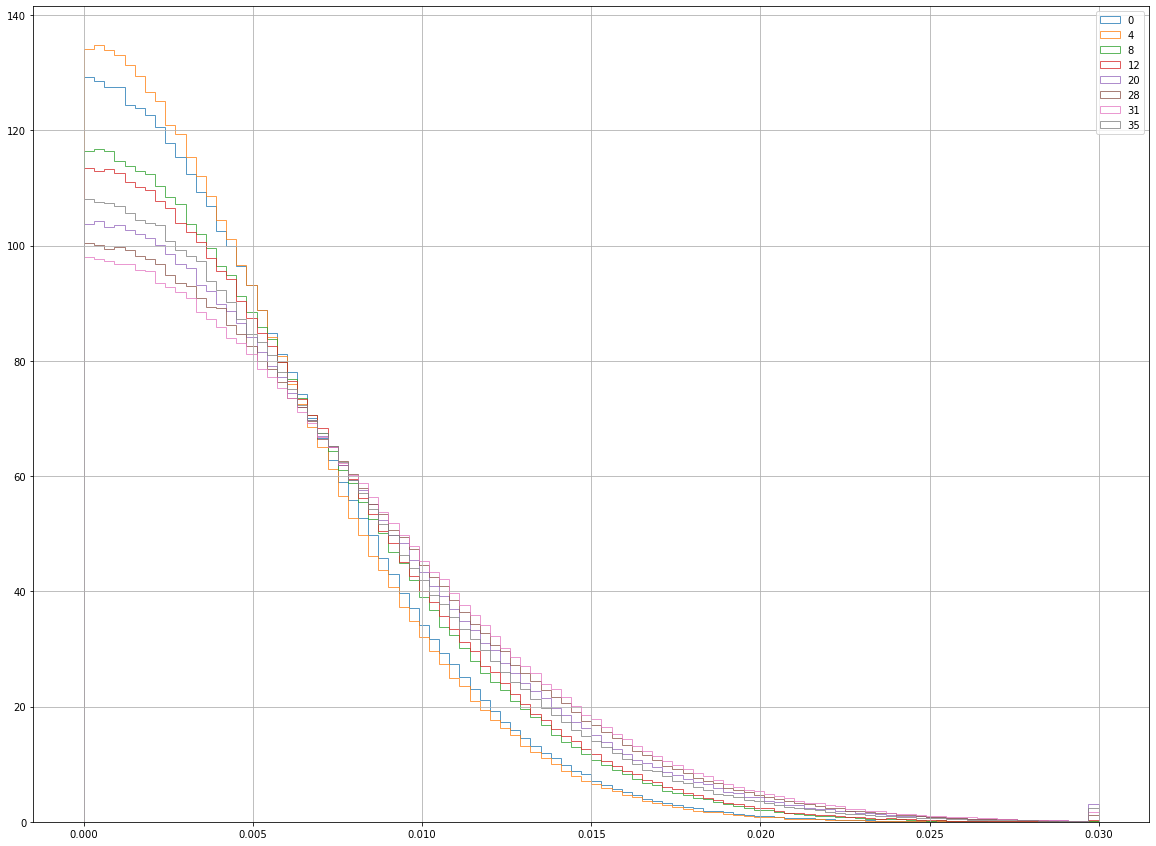

In [230]:
plot_wb_histogram(difference_tensor_dict['attn.c_proj.weight'],layers_to_plot=[0,4,8,12,20,28,31,35])

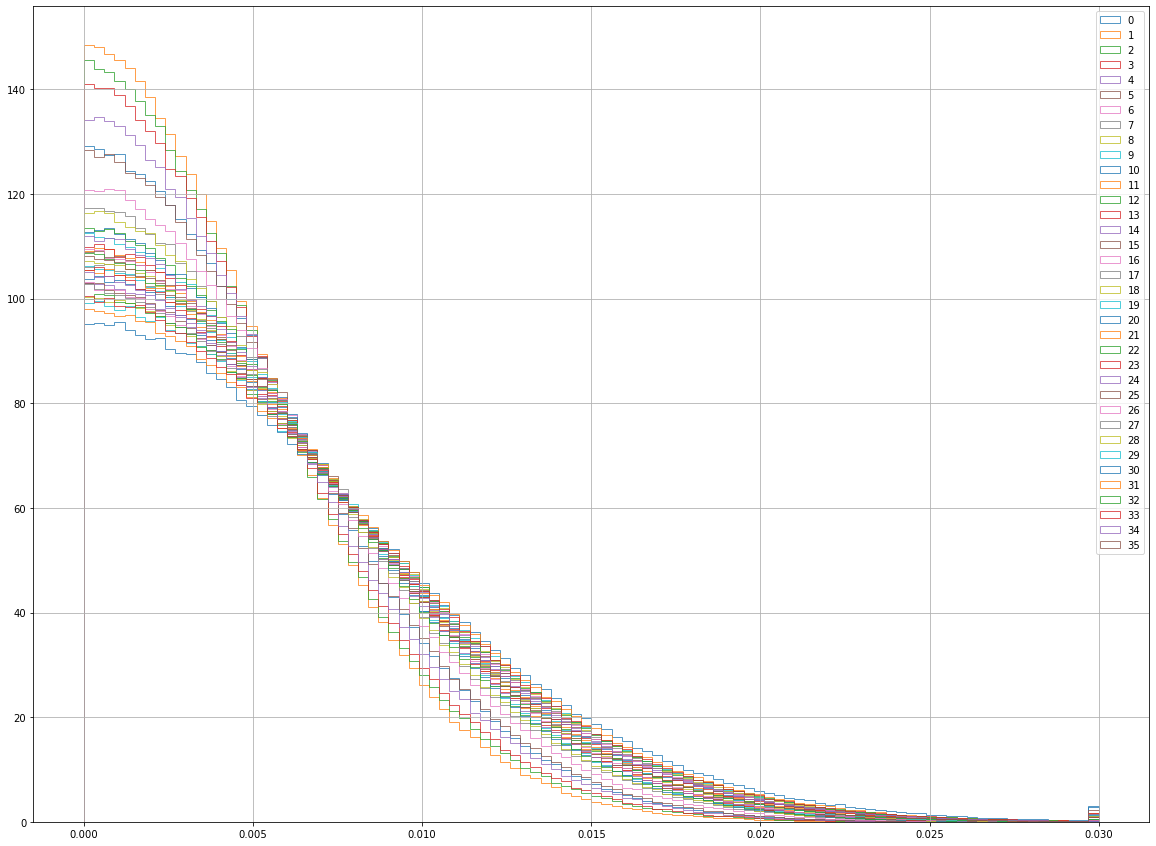

In [196]:
plot_wb_histogram(difference_tensor_dict['attn.c_proj.weight'])

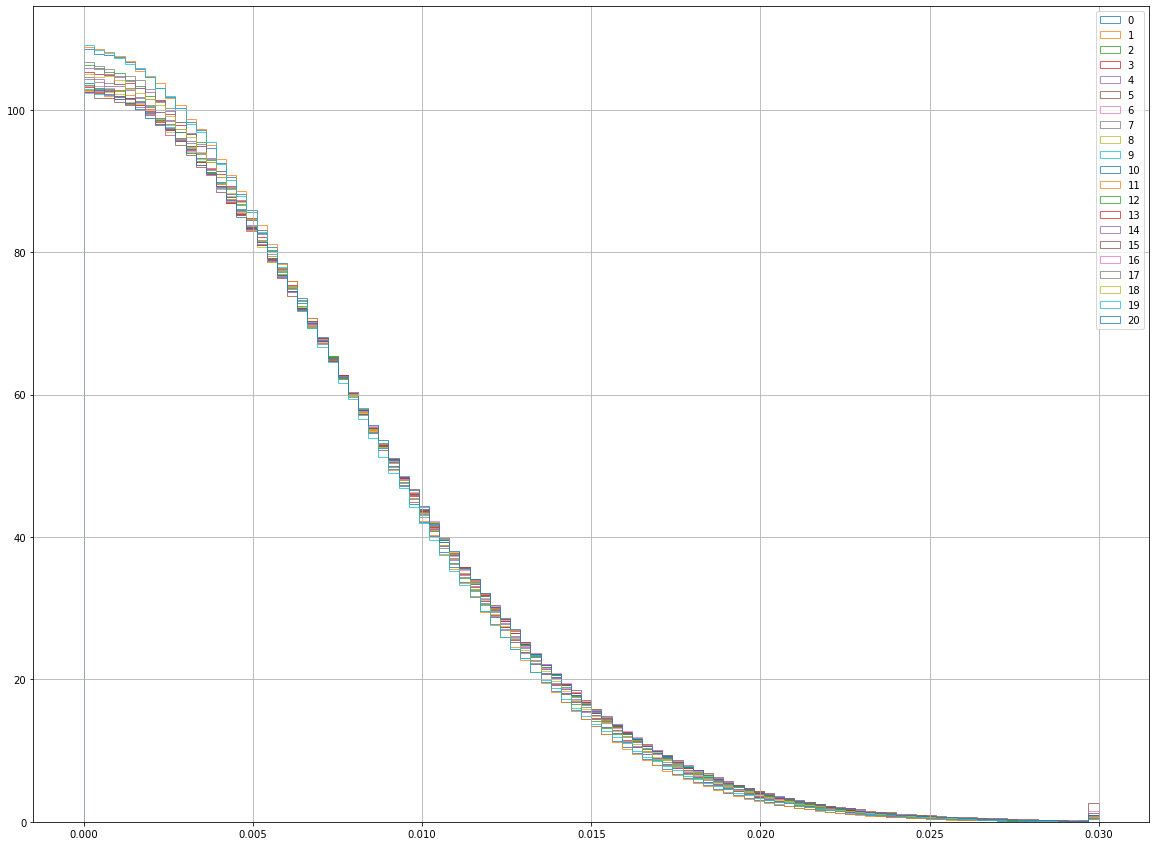

In [209]:
plot_wb_histogram(difference_tensor_dict['attn.c_attn.weight'][15:])

In [216]:
def plot_wb_std(wb):
    if type(wb) != list:
        wb = [wb]

    x = []
    y = []
    for layer,data in enumerate(wb):
        data = data.flatten()
        std = np.sqrt(np.sum(np.square(data))/len(data))
        x.append(layer)
        y.append(std)

    plt.scatter(x,y)
    plt.show()


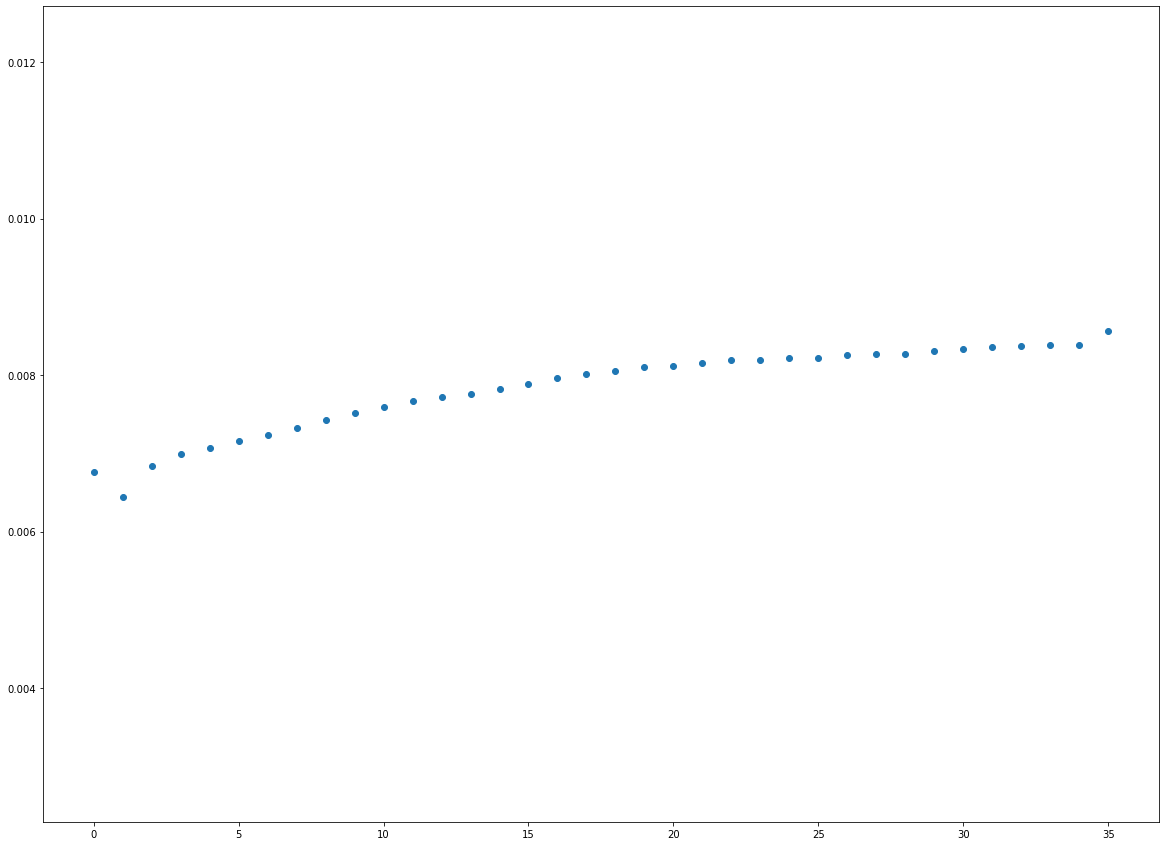

In [220]:
plot_wb_std(difference_tensor_dict['mlp.c_fc.weight'])

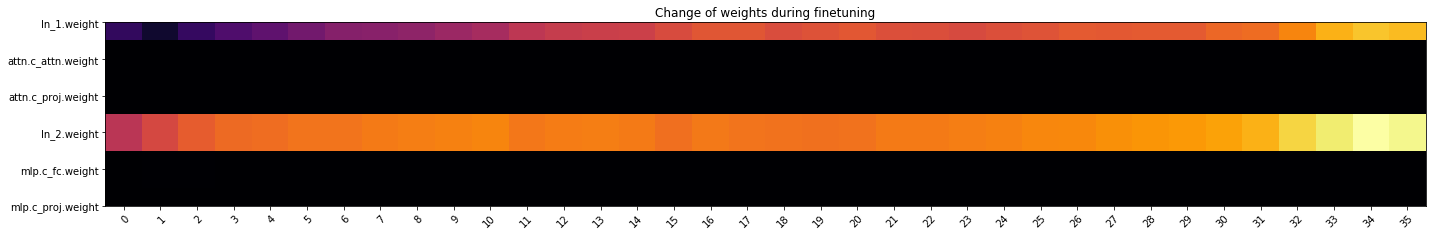

In [157]:
plot_wb_dict(weight_mean_dict)

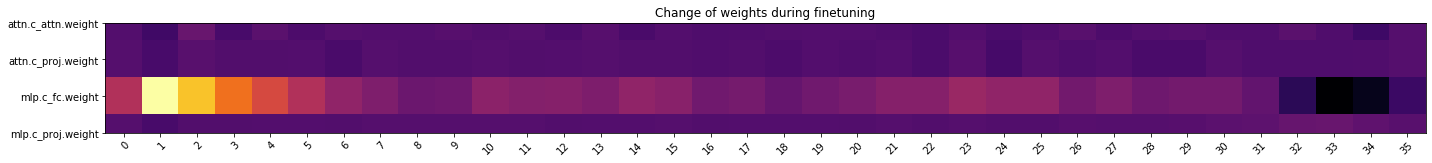

In [159]:
plot_wb_dict(weight_mean_no_ln_dict)

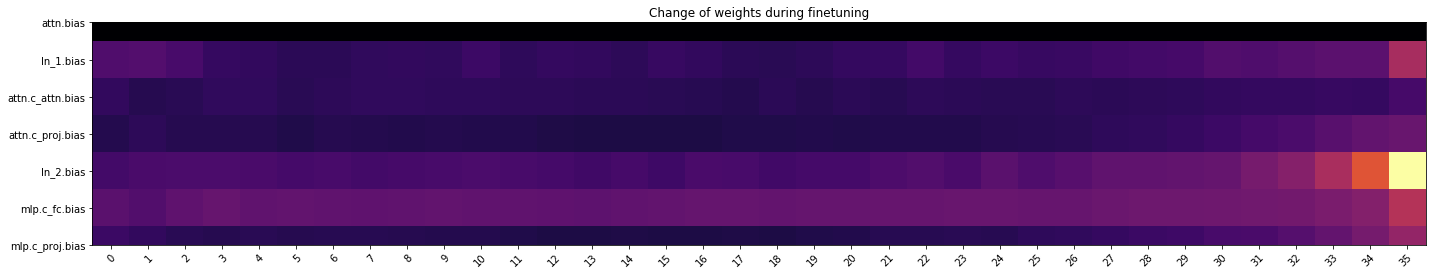

In [137]:
plot_wb_dict(bias_difference_dict)

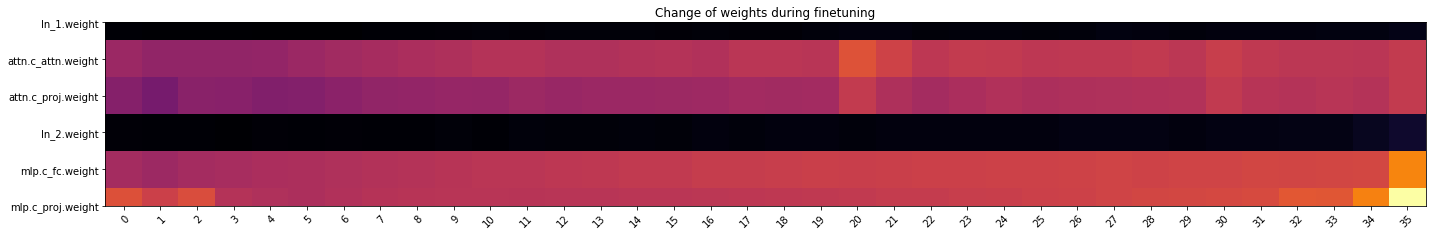

In [138]:
plot_wb_dict(weight_difference_dict)

/home/andreas/.conda/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


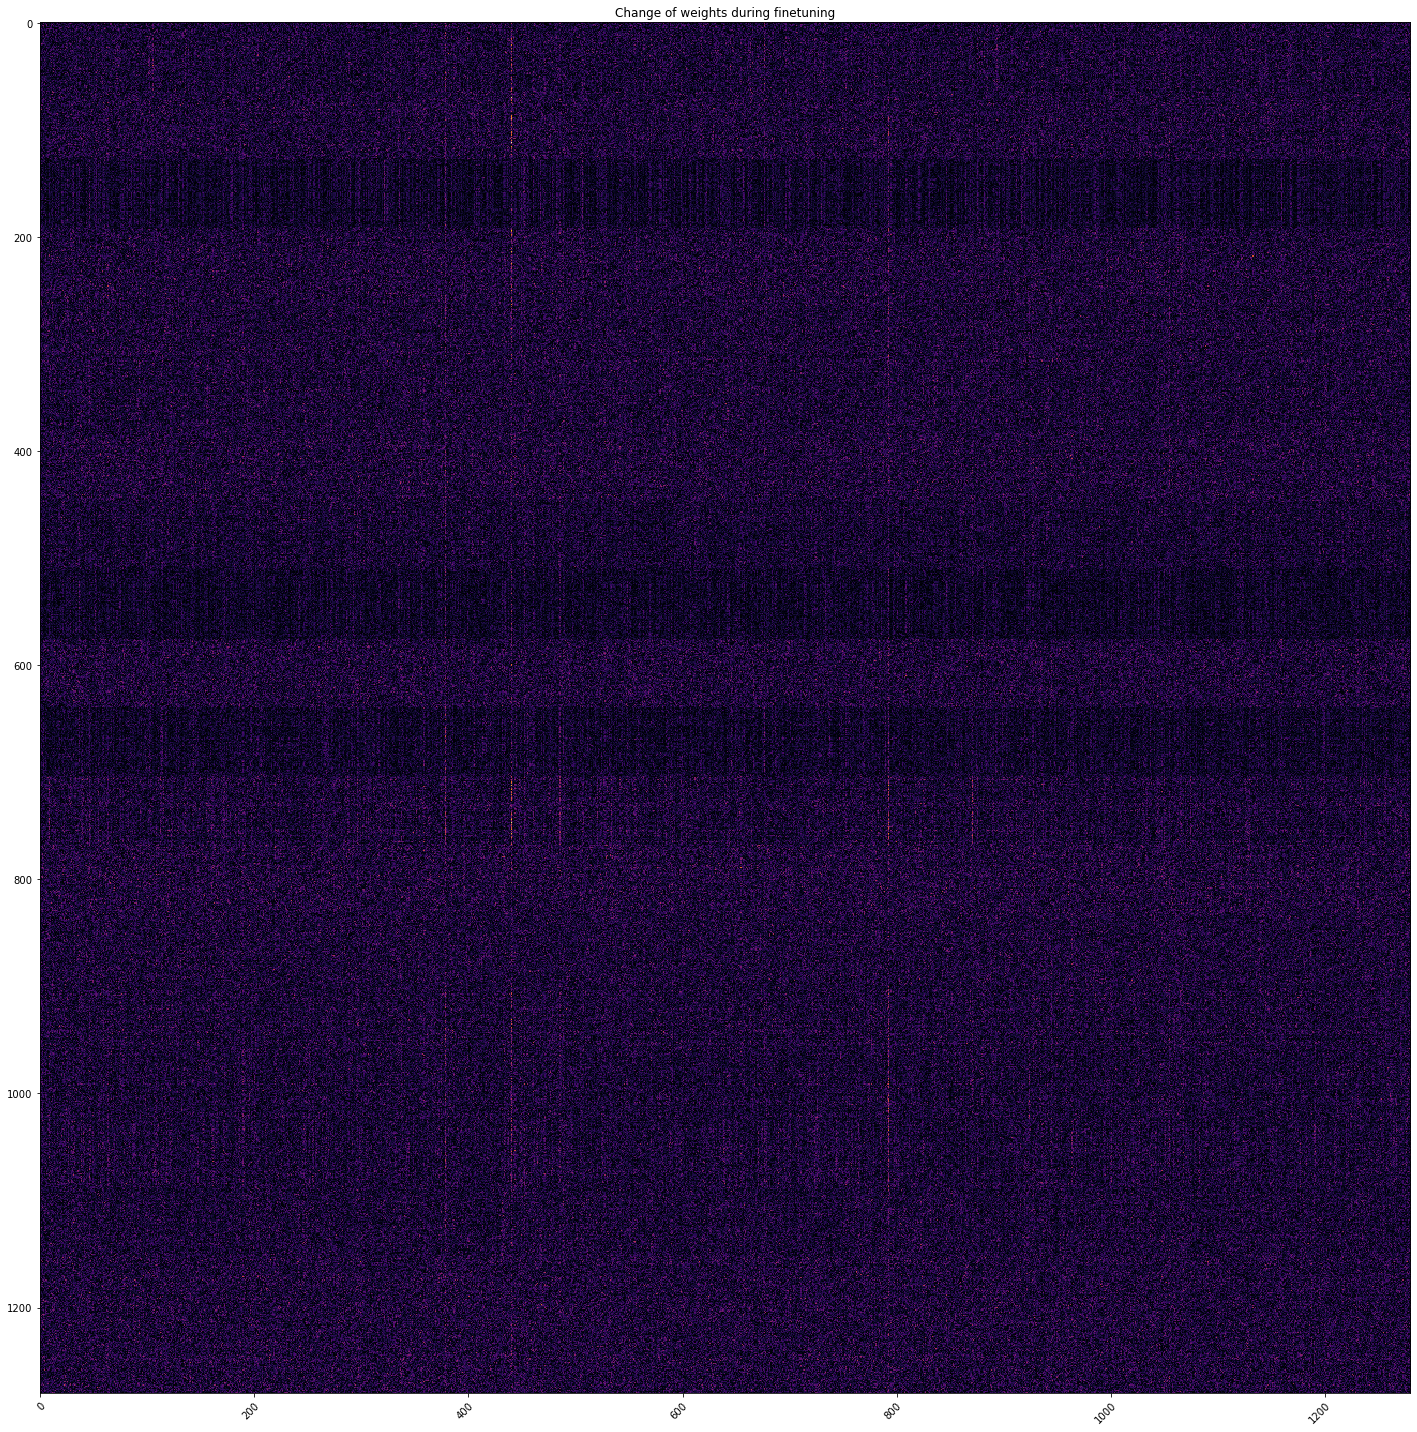

In [208]:
#blocks = difference_dict.keys()
#layers = ['layer '+str(layer) for layer in range(36)]

normalized = [np.asarray(item)/max(item) for item in list(difference_dict.values())]
heatmap = np.asarray(normalized)
heatmap = np.asarray(difference_tensor_dict['attn.c_proj.weight'][34])
fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(heatmap,cmap='inferno')

# Show all ticks and label them with the respective list entries
#ax.set_xticks(np.arange(len(layers)))

#ax.set_yticks(np.arange(len(difference_dict.keys())))
#ax.set_yticklabels(difference_dict.keys())

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.set_title("Change of weights during finetuning")
fig.tight_layout()
plt.show()